Este colab fue desarrollado por Arnold Charry Armero.

# Clustering Jerárquico

El Clustering Jerárquico es una técnica de aprendizaje no supervisado que busca agrupar observaciones con características similares sin necesidad de etiquetas previas. Su objetivo es construir una jerarquía de agrupamientos que permite explorar los datos desde los niveles más finos (cada punto como un grupo) hasta los más generales (un único clúster que contiene todos los datos).

A diferencia del K-Means, que requiere especificar previamente el número de clústers, el clustering jerárquico no necesita definirlo inicialmente. En su lugar, va formando agrupaciones paso a paso, lo que se representa mediante un dendrograma, un diagrama en forma de árbol que muestra cómo se fusionan los clústers a lo largo del proceso.

Para determinar cómo se agrupan los clústers en el clustering jerárquico, es necesario definir tanto una medida de distancia como un criterio de enlace. La medida de distancia permite cuantificar la similitud entre observaciones, siendo comunes la distancia euclidiana, la manhattan o la de coseno, según el tipo de datos. Por su parte, el criterio de enlace (linkage) define cómo se calcula la distancia entre clústers: puede tomarse la distancia mínima entre sus elementos (single linkage), la máxima (complete linkage), el promedio (average linkage) o la que minimiza la varianza dentro de los grupos (Ward linkage). La elección de estas métricas influye directamente en la forma del dendrograma y, por tanto, en la estructura final de los clústers obtenidos.

Ahora se continúa con la implementación en código.

In [ ]:
# Se importan las librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.compose import ColumnTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from pandas.api.types import is_numeric_dtype, is_object_dtype, is_string_dtype

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Bases de Datos/Mall_Customers.csv')

In [ ]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Se elimina la fila de CustomerID,

In [ ]:
df.drop('CustomerID', axis = 1, inplace = True)

In [ ]:
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


Primero se analiza la base de datos,

In [ ]:
# Se verifica la cantidad de datos
df.shape

(200, 4)

Se puede observar que hay 200 filas. Se observará de qué tipo son estos valores y si hay faltantes.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Genre                   200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [ ]:
# Se verifica el tema de los faltantes
df.isnull().sum()[df.isnull().sum() != 0]

,0


Ahora se analizan las características con datos relevantes,

In [ ]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


## Preprocesamiento de Datos

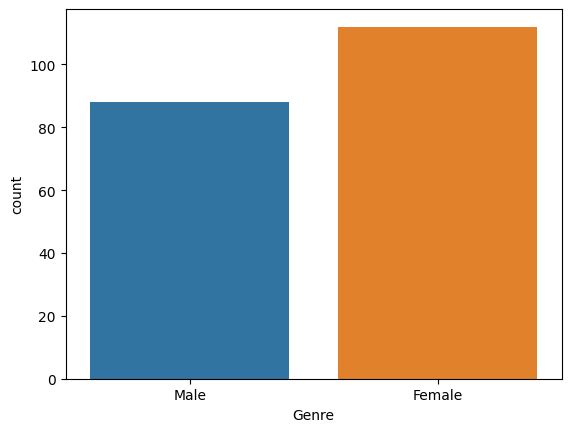

In [ ]:
# Gráfico de barras por cada clase
sns.countplot(data=df,x='Genre', hue='Genre')
plt.show()

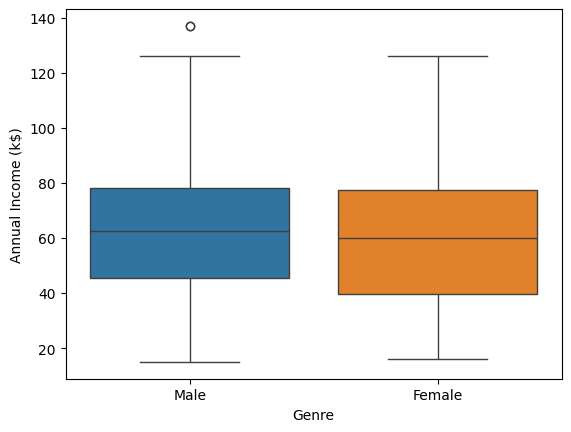

In [ ]:
# Gráfico de caja
sns.boxplot(x='Genre',y='Annual Income (k$)',data=df, hue='Genre')
plt.show()

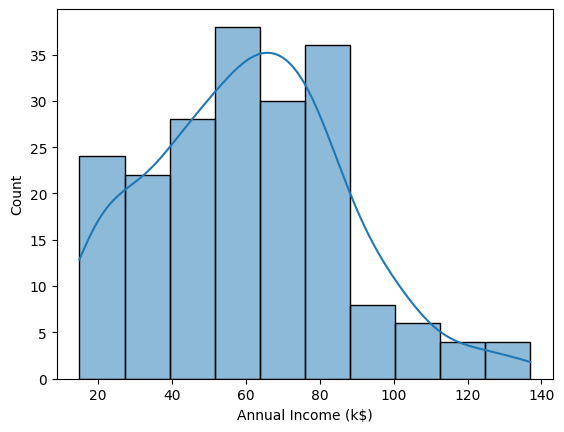

In [ ]:
sns.histplot(data = df, x = 'Annual Income (k$)', kde = True)
plt.show()

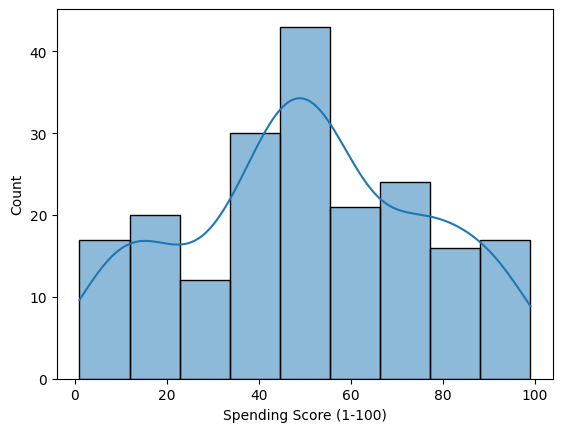

In [ ]:
sns.histplot(data = df, x = 'Spending Score (1-100)', kde = True)
plt.show()

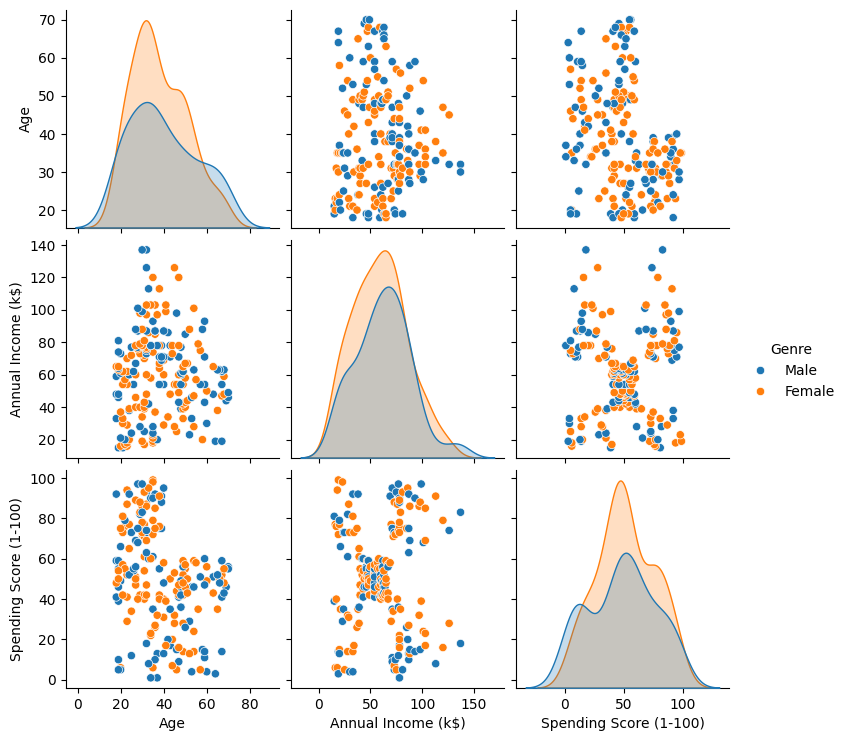

In [ ]:
sns.pairplot(df, hue='Genre')
plt.show()

Se realizará un análisis para las dos variables más importantes, las cuales son Annual Income (k$) y Spending Score. Posteriormente de este análisis, se hará un análisis para toda la base de datos.

In [ ]:
X = df.iloc[:, 2:].values

In [ ]:
# Escalado de datos
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
# Visualizar el array X
print(X)

[[0.         0.3877551 ]
 [0.         0.81632653]
 [0.00819672 0.05102041]
 [0.00819672 0.7755102 ]
 [0.01639344 0.39795918]
 [0.01639344 0.76530612]
 [0.02459016 0.05102041]
 [0.02459016 0.94897959]
 [0.03278689 0.02040816]
 [0.03278689 0.7244898 ]
 [0.03278689 0.13265306]
 [0.03278689 1.        ]
 [0.04098361 0.14285714]
 [0.04098361 0.7755102 ]
 [0.04098361 0.12244898]
 [0.04098361 0.79591837]
 [0.04918033 0.34693878]
 [0.04918033 0.66326531]
 [0.06557377 0.28571429]
 [0.06557377 0.98979592]
 [0.07377049 0.34693878]
 [0.07377049 0.73469388]
 [0.08196721 0.04081633]
 [0.08196721 0.73469388]
 [0.10655738 0.13265306]
 [0.10655738 0.82653061]
 [0.10655738 0.31632653]
 [0.10655738 0.6122449 ]
 [0.1147541  0.30612245]
 [0.1147541  0.87755102]
 [0.12295082 0.03061224]
 [0.12295082 0.73469388]
 [0.14754098 0.03061224]
 [0.14754098 0.92857143]
 [0.14754098 0.13265306]
 [0.14754098 0.81632653]
 [0.1557377  0.16326531]
 [0.1557377  0.73469388]
 [0.18032787 0.25510204]
 [0.18032787 0.75510204]


## Aprendizaje No Supervisado

Ahora se selecciona cuál es la cantidad de clústers óptima por medio del Dendrograma. Con base en esto, se toma la decisión de segmentar los datos por tipo de grupo.

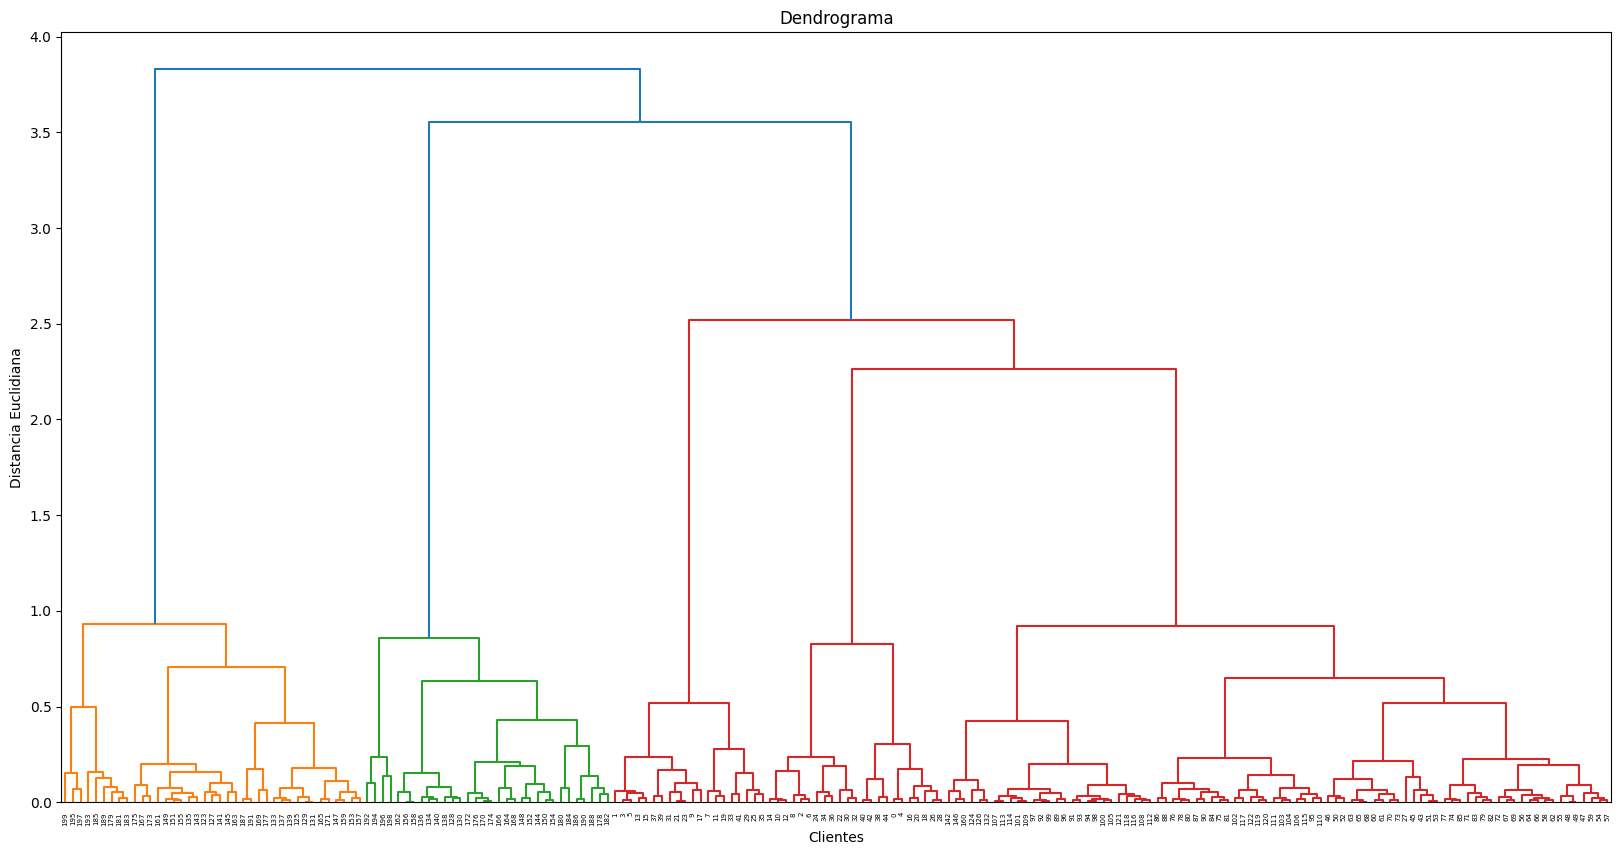

In [ ]:
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(sch.linkage(X, method = "ward"))
plt.title("Dendrograma")
plt.xlabel("Clientes")
plt.ylabel("Distancia Euclidiana")
plt.show()

## Segmentación con Clustering Jerárquico

In [ ]:
hc = AgglomerativeClustering(n_clusters = 5, metric = "euclidean", linkage = "ward")
y_hc = hc.fit_predict(X)

In [ ]:
# Se desescalan los datos y los centroides
X_original = scaler.inverse_transform(X)

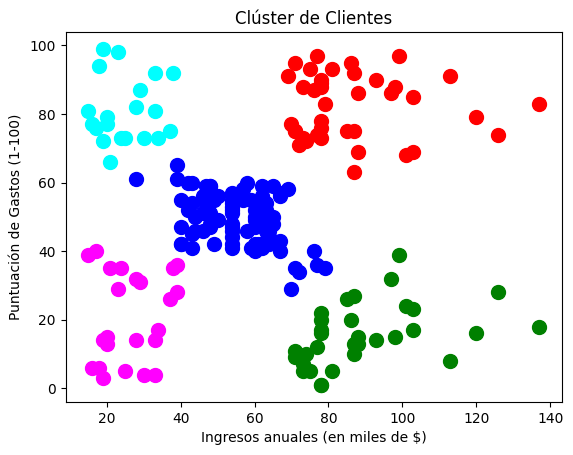

In [ ]:
# Visualización de los clusters
plt.scatter(X_original[y_hc == 0, 0], X_original[y_hc == 0, 1], s = 100, c = "red", label = "Cautos")
plt.scatter(X_original[y_hc == 1, 0], X_original[y_hc == 1, 1], s = 100, c = "blue", label = "Estándar")
plt.scatter(X_original[y_hc == 2, 0], X_original[y_hc == 2, 1], s = 100, c = "green", label = "Objetivo")
plt.scatter(X_original[y_hc == 3, 0], X_original[y_hc == 3, 1], s = 100, c = "cyan", label = "Descuidados")
plt.scatter(X_original[y_hc == 4, 0], X_original[y_hc == 4, 1], s = 100, c = "magenta", label = "Conservadores")
plt.title("Clúster de Clientes")
plt.xlabel("Ingresos anuales (en miles de $)")
plt.ylabel("Puntuación de Gastos (1-100)")
plt.show()

## Más de Dos Variables

Ahora se realiza el mismo proceso, pero para todas las características,

In [ ]:
# Obtenemos las características
X = df.iloc[:, :].values

In [ ]:
# Se detectan las columnas categóricas
cat_cols = df.select_dtypes(include=['object', 'category'])
cat_indices = [df.columns.get_loc(col) for col in cat_cols]

# Se detectan las columnas numéricas
num_indices = [i for i in range(df.shape[1]) if i not in cat_indices]

# Se crea el transformador
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(drop='first',sparse_output=False, dtype=int), cat_indices),
                  ('scaler', MinMaxScaler(), num_indices)],
    remainder='passthrough')


# Se aplica al array X
X = np.array(ct.fit_transform(X))

In [ ]:
# Visualizar el array X
print(X)

[[1.         0.01923077 0.         0.3877551 ]
 [1.         0.05769231 0.         0.81632653]
 [0.         0.03846154 0.00819672 0.05102041]
 [0.         0.09615385 0.00819672 0.7755102 ]
 [0.         0.25       0.01639344 0.39795918]
 [0.         0.07692308 0.01639344 0.76530612]
 [0.         0.32692308 0.02459016 0.05102041]
 [0.         0.09615385 0.02459016 0.94897959]
 [1.         0.88461538 0.03278689 0.02040816]
 [0.         0.23076923 0.03278689 0.7244898 ]
 [1.         0.94230769 0.03278689 0.13265306]
 [0.         0.32692308 0.03278689 1.        ]
 [0.         0.76923077 0.04098361 0.14285714]
 [0.         0.11538462 0.04098361 0.7755102 ]
 [1.         0.36538462 0.04098361 0.12244898]
 [1.         0.07692308 0.04098361 0.79591837]
 [0.         0.32692308 0.04918033 0.34693878]
 [1.         0.03846154 0.04918033 0.66326531]
 [1.         0.65384615 0.06557377 0.28571429]
 [0.         0.32692308 0.06557377 0.98979592]
 [1.         0.32692308 0.07377049 0.34693878]
 [1.         

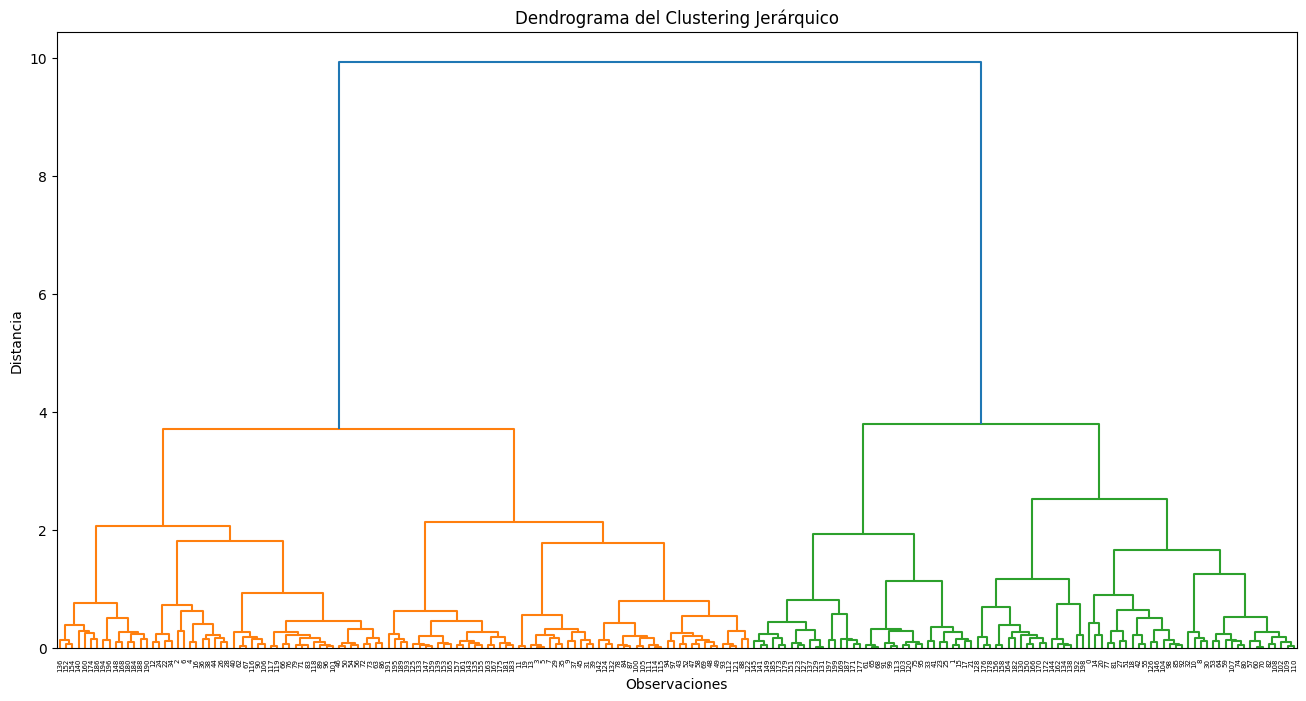

In [ ]:
# Dendrograma de todas las características
linkage_matrix = sch.linkage(X, method='ward')
plt.figure(figsize=(16, 8))
plt.title('Dendrograma del Clustering Jerárquico')
plt.xlabel('Observaciones')
plt.ylabel('Distancia')
sch.dendrogram(linkage_matrix, truncate_mode=None)
plt.show()

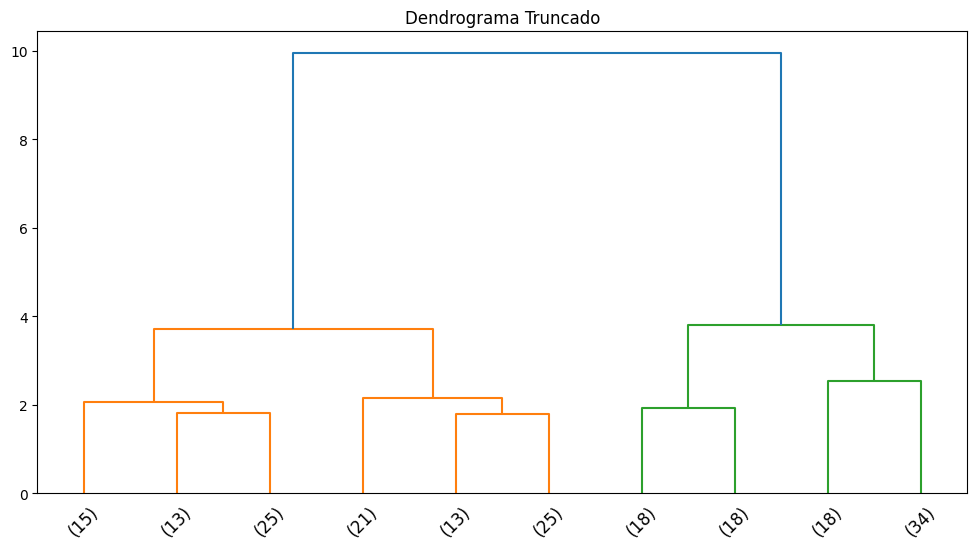

In [ ]:
# Dendrograma truncado
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix, truncate_mode='lastp', p=10, leaf_rotation=45.)
plt.title('Dendrograma Truncado')
plt.show()

In [ ]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=10)
model.fit(X)

AgglomerativeClustering(distance_threshold=10, n_clusters=None)

In [ ]:
print(f"Número de fusiones: {len(model.children_)}")

Número de fusiones: 199


In [ ]:
for k in range(2, 7):
    labels = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X)
    score = silhouette_score(X, labels)
    print(f'k={k}, Silhouette={score:.3f}')

k=2, Silhouette=0.519
k=3, Silhouette=0.447
k=4, Silhouette=0.344
k=5, Silhouette=0.350
k=6, Silhouette=0.346


In [ ]:
# Se determina número óptimo de clústers usando linkage_matrix
last = linkage_matrix[-10:, 2]
diff = np.diff(last)
optimal_clusters = np.argmax(diff[::-1]) + 2  # +2 porque diff reduce en 1
print(f"Número óptimo de clústers sugerido: {optimal_clusters}")

Número óptimo de clústers sugerido: 2


In [ ]:
model_final = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
labels = model_final.fit_predict(X)

In [ ]:
# Se agregan los clústers
df['Cluster'] = labels

In [ ]:
# Se hace un análisis descriptivo de cada clúster
num_cols = df.select_dtypes(include=np.number).columns.tolist()

cluster_summary = df.groupby('Cluster')[num_cols].agg(['mean', 'count'])
display(cluster_summary)

Age       Annual Income (k$)       Spending Score (1-100)  \
              mean count               mean count                   mean   
Cluster                                                                    
0        39.806818    88          62.227273    88              48.511364   
1        38.098214   112          59.250000   112              51.526786   

              Cluster        
        count    mean count  
Cluster                      
0          88     0.0    88  
1         112     1.0   112

## Referencias

*   Jacinto, V. R. (2024). Machine learning: Fundamentos, algoritmos y aplicaciones para los negocios, industria y finanzas. Ediciones Díaz de Santos.
*   James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning: with Applications in R. https://link.springer.com/content/pdf/10.1007/978-1-0716-1418-1.pdf
*   Mall customers. (2019, April 29). Kaggle. https://www.kaggle.com/datasets/kandij/mall-customers